In [ ]:
# pip install openpyxl
# pip install pandas
# pip install opencv
# pip install matplotlib
# pip install tensorflow
# pip install scikit-learn
# pip install -q python-levenshtein

In [1]:
import numpy as np
import cv2
import pandas as pd
import string
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
with open('datasets/words_train_data/words_new.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents][18:]
lines[0]

'a01-000u-00-00 ok 154 408 768 27 51 AT A'

In [3]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [4]:
images = []
labels = []

RECORDS_COUNT = 10000

In [5]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [6]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
#     _, img = cv2.threshold(img, 
#                            128, 
#                            255, 
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

In [7]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = 'datasets/words_train_data/words/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
        
        # processing on image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # processing on label
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

In [8]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [9]:
train_padded_label.shape, valid_padded_label.shape

((2413, 16), (269, 16))

In [10]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [11]:
train_images.shape

(2413, 32, 128, 1)

In [12]:


# input with shape of height=32 and width=128
inputs = Input(shape=(32, 128, 1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
# pooling layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation='relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation='relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation='relu', padding='same')(conv_3)

# pooling layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation='relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation='relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation='relu')(pool_6)

squeezed = Lambda(lambda x: tf.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation='softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)
act_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 128, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 32, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 32, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 32, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 32, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 31, 512)     │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 31, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 31, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 31, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31, 79)         │        40,527 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,743,247 (33.35 MB)

 Trainable params: 8,741,199 (33.35 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [13]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [14]:
batch_size = 8
epochs = 30
e = str(epochs)
optimizer_name = 'sgd'

In [15]:
# Define the directory path within /kaggle/output/
checkpoint_directory = 'model/checkpoint_1/' # /kaggle/output/checkpoint_1/

# Create the directory if it doesn't exist
if not os.path.exists(checkpoint_directory):
    os.makedirs(checkpoint_directory)  # Use os.makedirs() to create parent directories if needed

# Now you can save your data or model checkpoints to the checkpoint_directory
# For example, if you want to save a model checkpoint:
# model.save(os.path.join(checkpoint_directory, 'my_model.h5'))

In [16]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="model/checkpoint_1/{}o-{}r-{}e-{}t-{}v.keras".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [17]:
import tensorflow as tf
from tensorflow.keras import backend as K

def ctc_lambda_func(y_true, y_pred):
    # y_true is expected to be a list or tuple containing:
    # - labels (true labels, padded)
    # - input_length (lengths of the inputs)
    # - label_length (lengths of the labels)
    
    labels = y_true[0]  # Tensor of shape (batch_size, max_label_length)
    input_length = y_true[1]  # Tensor of shape (batch_size,)
    label_length = y_true[2]  # Tensor of shape (batch_size,)

    # Compute CTC loss using backend function
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


In [18]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/30


Epoch 1: val_loss improved from inf to 16.54260, saving model to model/checkpoint_1/sgdo-10000r-30e-2413t-269v.keras


d:\codes\project\OCR\environment\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

  return {key: serialize_keras_object(value) for key, value in obj.items()}


302/302 - 120s - 399ms/step - accuracy: 0.0000e+00 - loss: 17.3195 - val_accuracy: 0.0000e+00 - val_loss: 16.5426
Epoch 2/30

Epoch 2: val_loss improved from 16.54260 to 15.67043, saving model to model/checkpoint_1/sgdo-10000r-30e-2413t-269v.keras
302/302 - 123s - 407ms/step - accuracy: 0.0000e+00 - loss: 15.3246 - val_accuracy: 0.0000e+00 - val_loss: 15.6704
Epoch 3/30

Epoch 3: val_loss did not improve from 15.67043
302/302 - 123s - 408ms/step - accuracy: 0.0000e+00 - loss: 14.6742 - val_accuracy: 0.0000e+00 - val_loss: 15.7675
Epoch 4/30

Epoch 4: val_loss improved from 15.67043 to 15.06833, saving model to model/checkpoint_1/sgdo-10000r-30e-2413t-269v.keras
302/302 - 110s - 365ms/step - accuracy: 0.0000e+00 - loss: 14.0130 - val_accuracy: 0.0000e+00 - val_loss: 15.0683
Epoch 5/30

Epoch 5: val_loss improved from 15.06833 to 14.57765, saving model to model/checkpoint_1/sgdo-10000r-30e-2413t-269v.keras
302/302 - 139s - 459ms/step - accuracy: 0.0033 - loss: 13.4028 - val_accuracy: 0.0

In [19]:
# Saving the history object in excel file using pandas. 
# pip install openpyxl 

history_dict = {
    'epoch': list(range(1, len(history.history['loss']) + 1)),
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy']
}
history_df = pd.DataFrame(history_dict)
excel_file_path = 'model/working/training_history.xlsx'  # Replace with your desired file path
history_df.to_excel(excel_file_path, index=False)

In [20]:
# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0
total_rati = 0
# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
    total_rati+=lv.ratio(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))
print('ratio:', total_rati/len(out))

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step
jaro : 0.8299995887356478
ratio: 0.7865176879683431


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
original_text =   to
predicted text = to

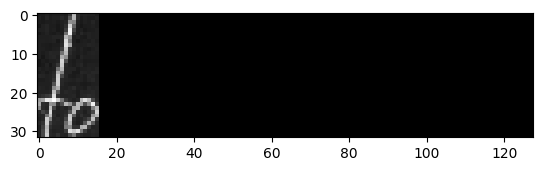



original_text =   cease
predicted text = cease

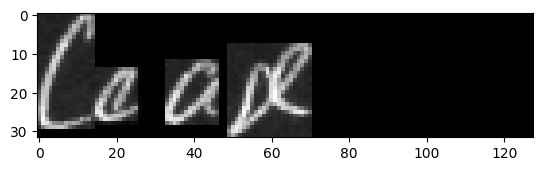



original_text =   his
predicted text = his

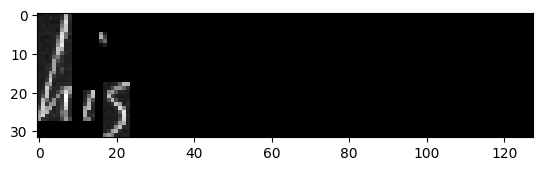



original_text =   negotiations
predicted text = negotitios

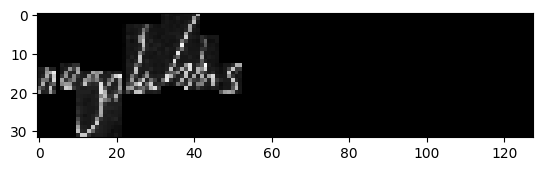



original_text =   with
predicted text = with

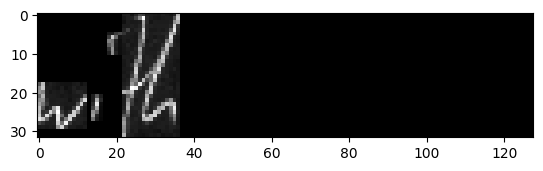



original_text =   interference
predicted text = interfence

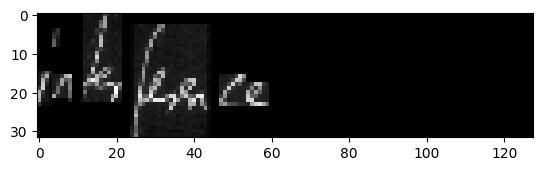



original_text =   Sir
predicted text = Sirt

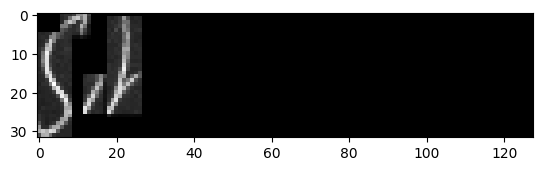



original_text =   Roy's
predicted text = Roy's

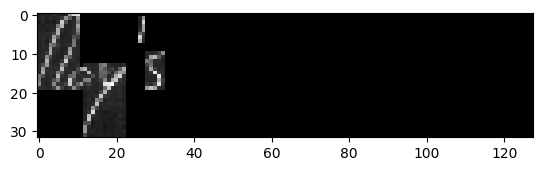



original_text =   Federal
predicted text = Federal

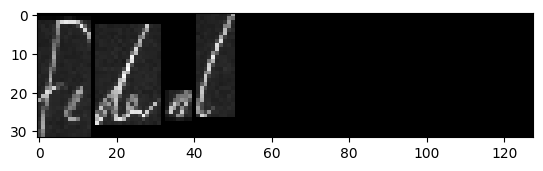



original_text =   Government
predicted text = Gocernment

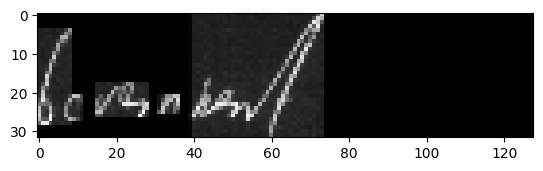



original_text =   in
predicted text = in

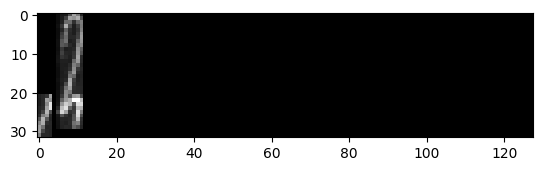



original_text =   the
predicted text = the

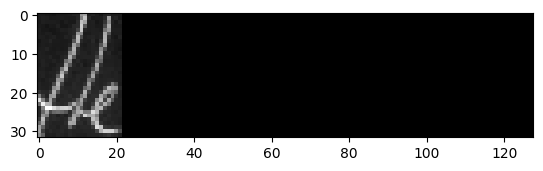



original_text =   talks
predicted text = talks

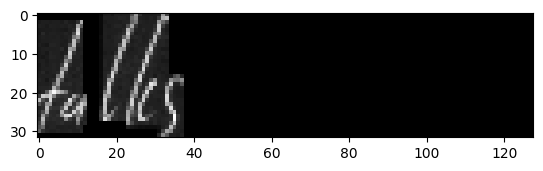



original_text =   .
predicted text = .

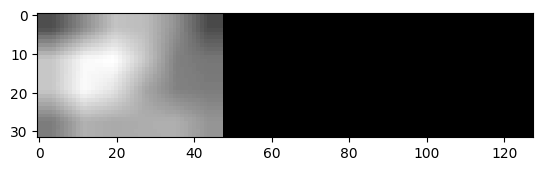



original_text =   sparked
predicted text = sparked

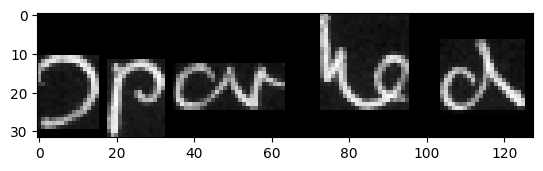



original_text =   off
predicted text = off

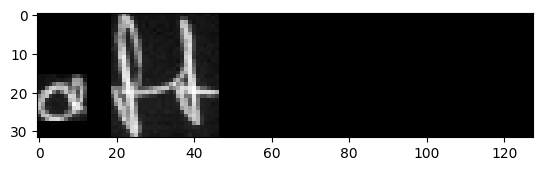



original_text =   the
predicted text = the

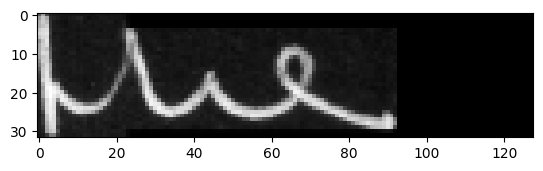



original_text =   opposition
predicted text = opposition

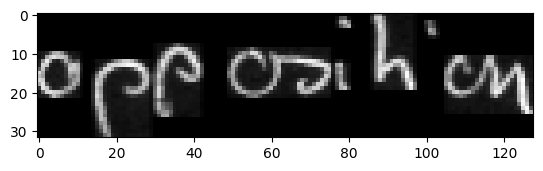



original_text =   by
predicted text = by

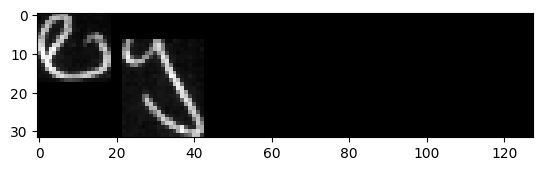



original_text =   telling
predicted text = telling

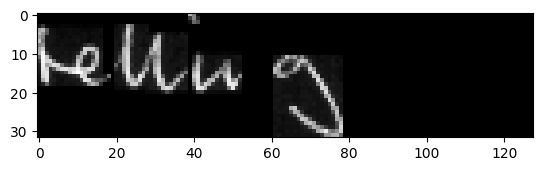



original_text =   a
predicted text = a

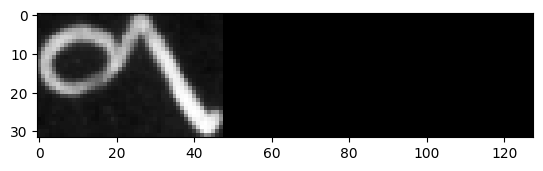



original_text =   audience
predicted text = audience

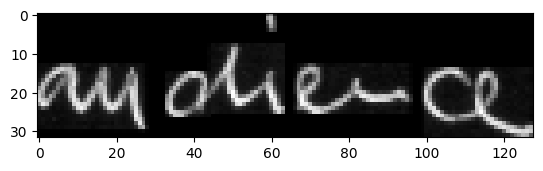



original_text =   it
predicted text = it

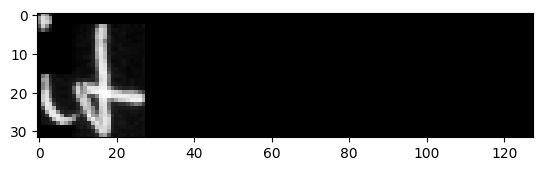



original_text =   was
predicted text = was

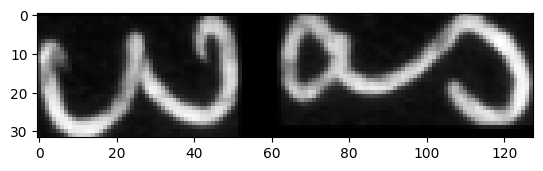



original_text =   "
predicted text = "

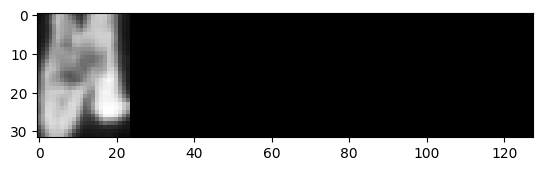



original_text =   current
predicted text = current

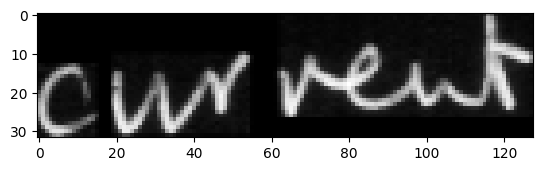



original_text =   Washington
predicted text = Washington

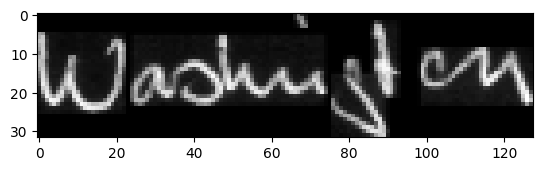



original_text =   gossip
predicted text = gossip

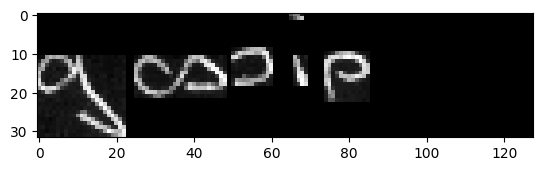



original_text =   "
predicted text = "

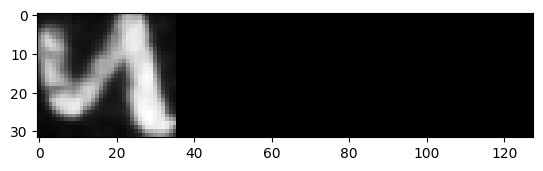



original_text =   that
predicted text = that

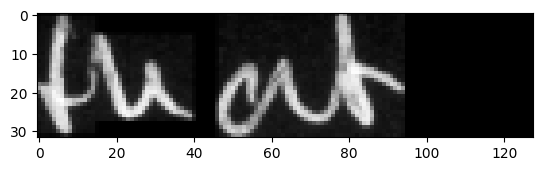



original_text =   once
predicted text = once

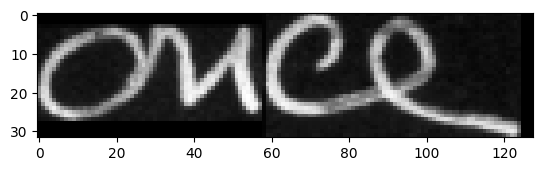



original_text =   had
predicted text = had

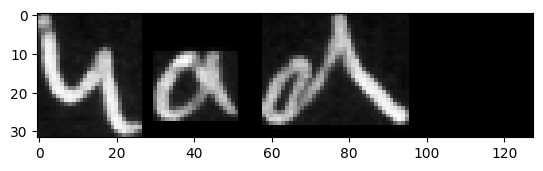



original_text =   Communist
predicted text = Communist

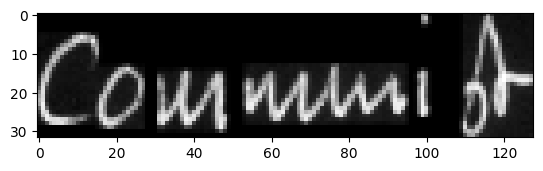



original_text =   affilia-
predicted text = affilia-

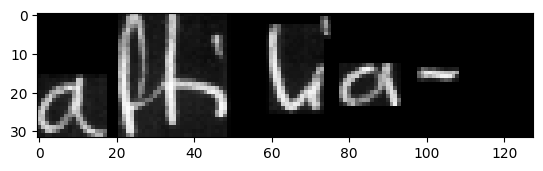



original_text =   tions
predicted text = tions

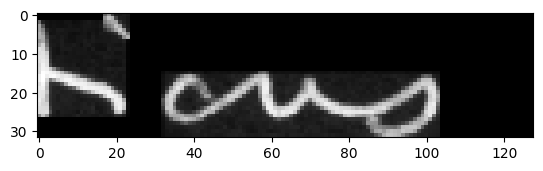



original_text =   .
predicted text = .

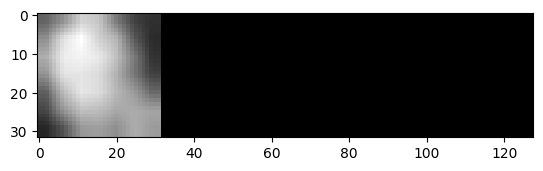



original_text =   The
predicted text = The

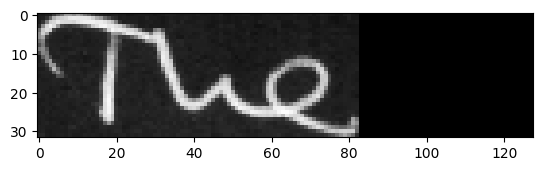



original_text =   Senate
predicted text = Senate

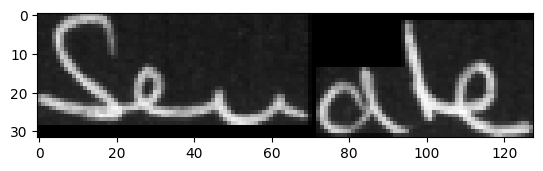



original_text =   Banking
predicted text = Banking

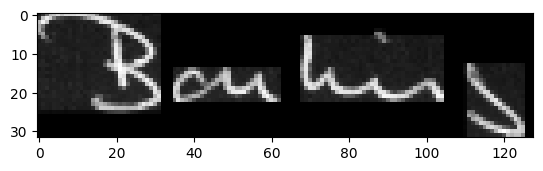



original_text =   ,
predicted text = ,

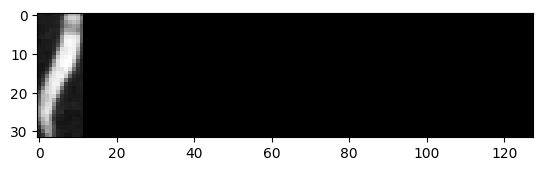



original_text =   which
predicted text = which

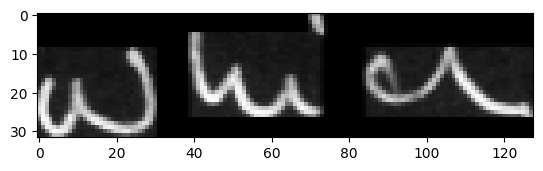



original_text =   is
predicted text = is

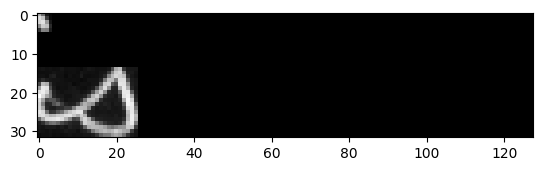



original_text =   headed
predicted text = headed

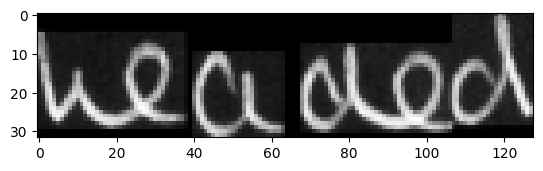



original_text =   by
predicted text = by

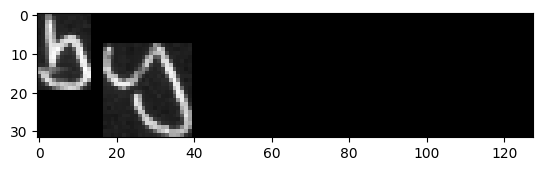



original_text =   another
predicted text = another

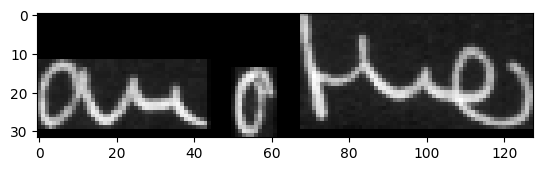



original_text =   Southern
predicted text = Southern

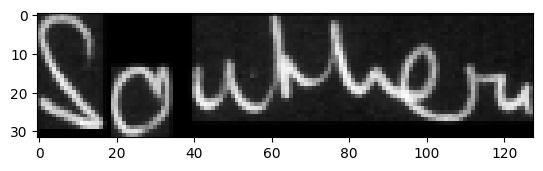



original_text =   Senator
predicted text = Senator

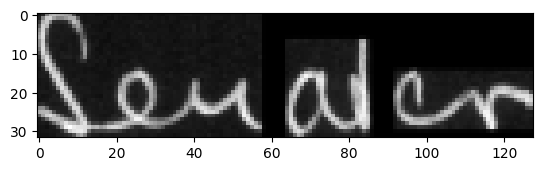



original_text =   -
predicted text = -

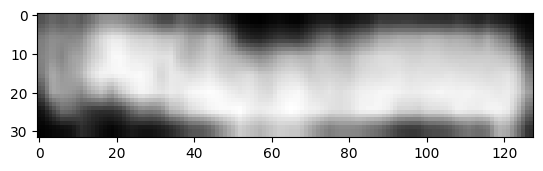



original_text =   Robertson
predicted text = Robertson

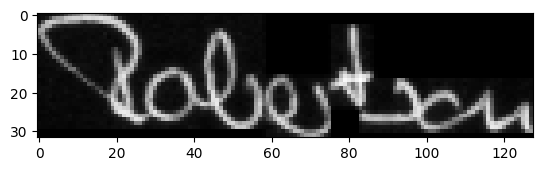



original_text =   ,
predicted text = ,

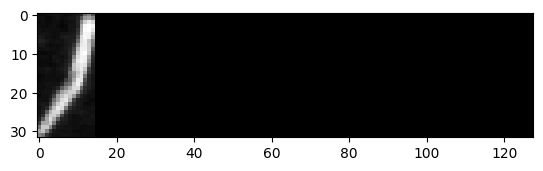



original_text =   of
predicted text = of

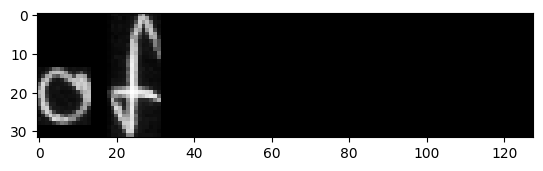



original_text =   Virginia
predicted text = Virginia

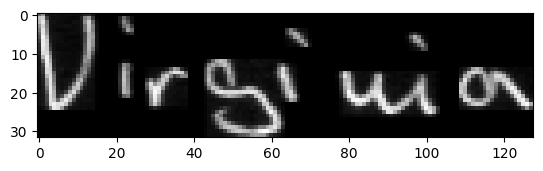



original_text =   -
predicted text = -

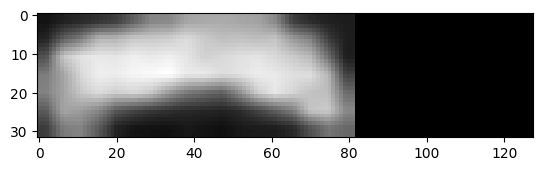



original_text =   met
predicted text = met

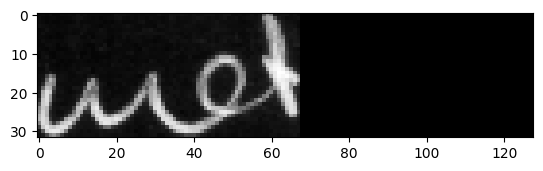



original_text =   today
predicted text = today

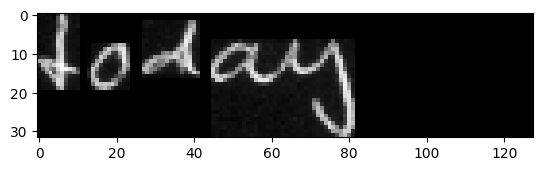



original_text =   in
predicted text = in

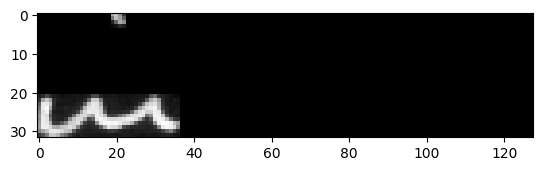



original_text =   Senator
predicted text = Senator

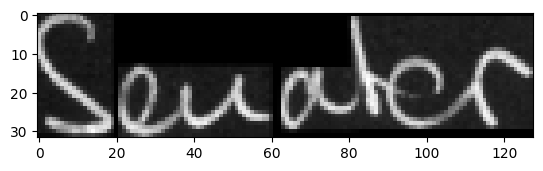



original_text =   Robertson
predicted text = Robertson

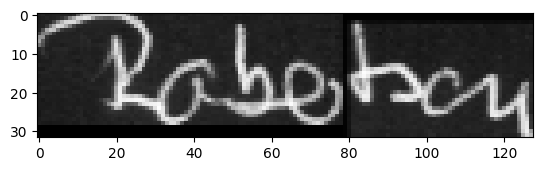



original_text =   later
predicted text = later

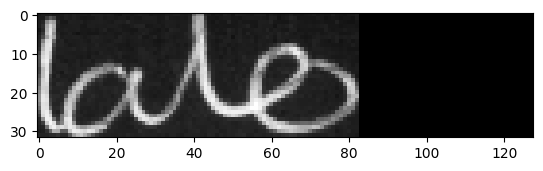



original_text =   disclosed
predicted text = disclosed

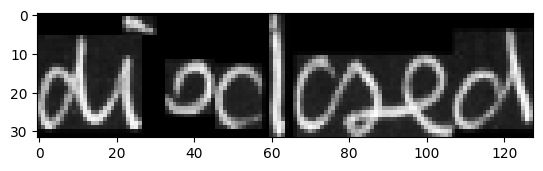



original_text =   had
predicted text = had

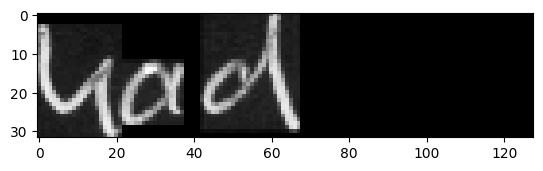



original_text =   sent
predicted text = sent

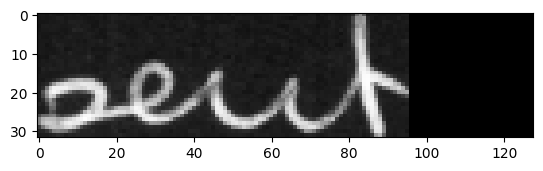



original_text =   a
predicted text = a

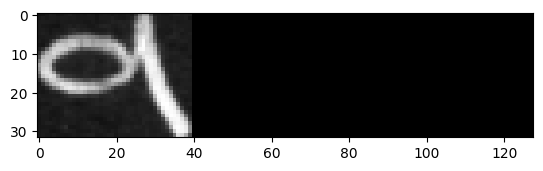



original_text =   letter
predicted text = letter

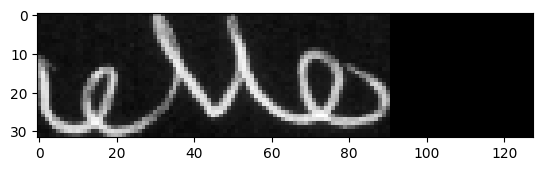



original_text =   to
predicted text = to

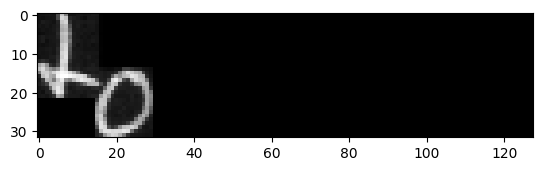



original_text =   Mr.
predicted text = Mr.

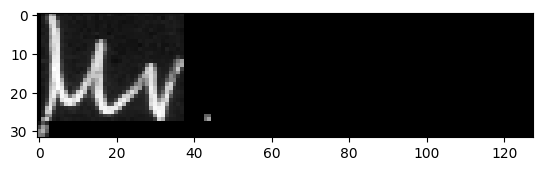



original_text =   Kennedy
predicted text = Kennedy

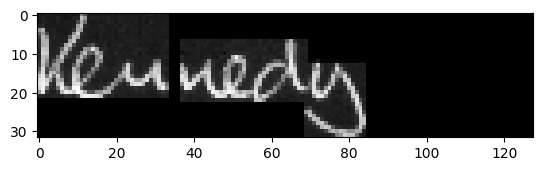



original_text =   saying
predicted text = saying

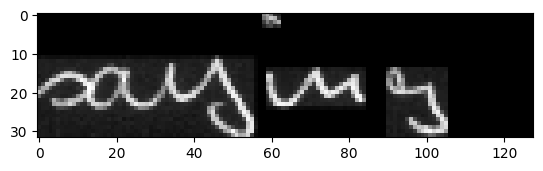



original_text =   he
predicted text = he

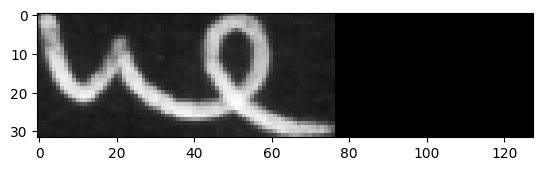



original_text =   received
predicted text = received

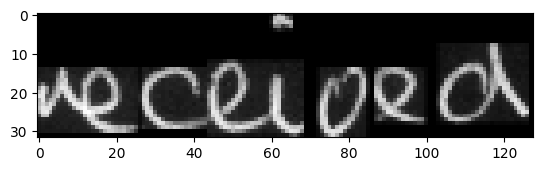



original_text =   several
predicted text = several

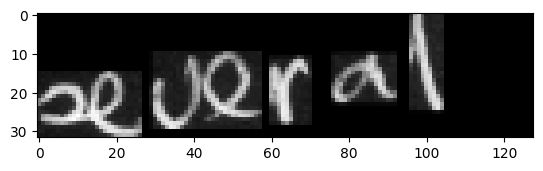



original_text =   complaints
predicted text = complaints

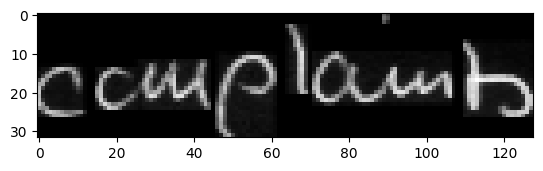



original_text =   about
predicted text = about

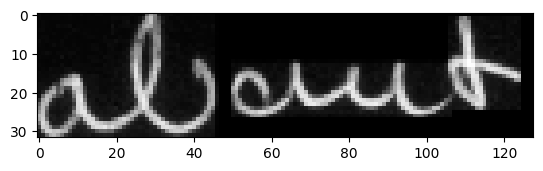



original_text =   Weaver's
predicted text = beaver's

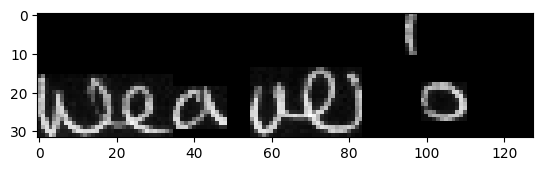



original_text =   loyalty
predicted text = loyalty

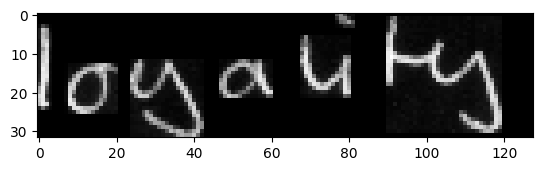



original_text =   .
predicted text = .

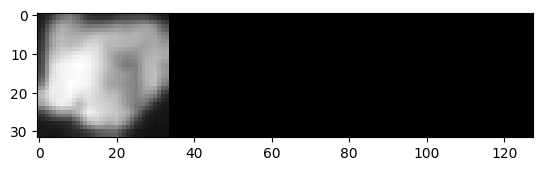



original_text =   level
predicted text = level

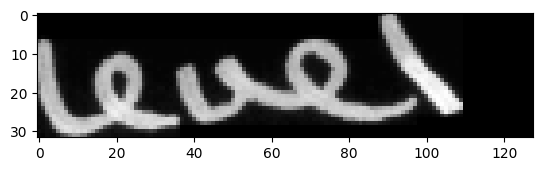



original_text =   than
predicted text = tha

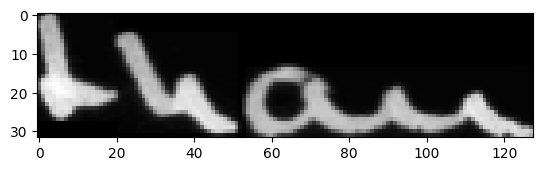



original_text =   in
predicted text = in

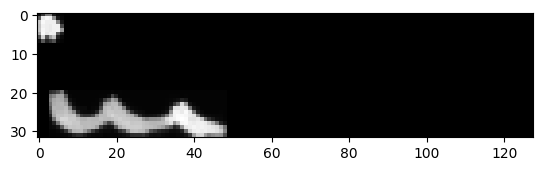



original_text =   the
predicted text = the

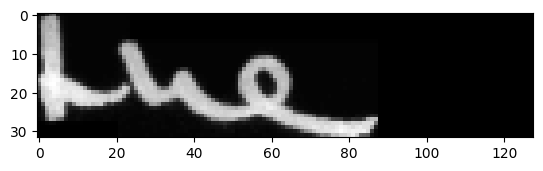



original_text =   past
predicted text = past

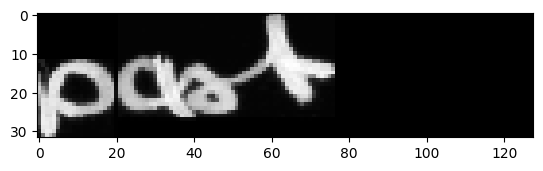



original_text =   "
predicted text = "

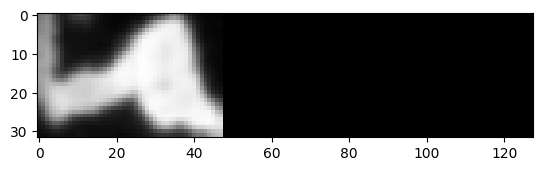



original_text =   be
predicted text = be

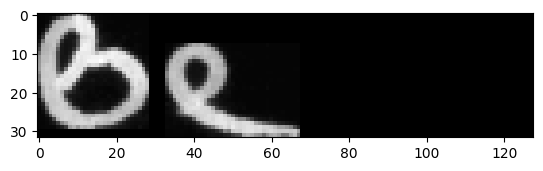



original_text =   useful
predicted text = useful

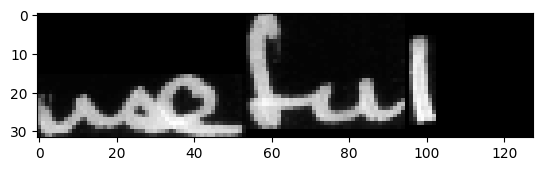



original_text =   .
predicted text = .

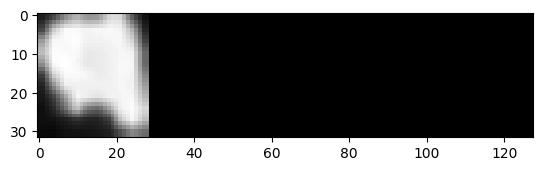



original_text =   The
predicted text = The

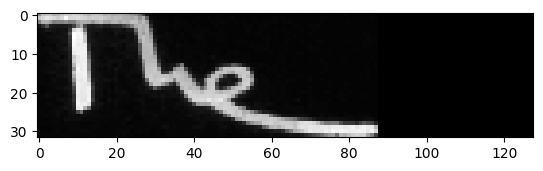



original_text =   President
predicted text = President

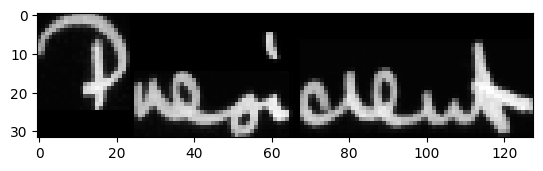



original_text =   will
predicted text = will

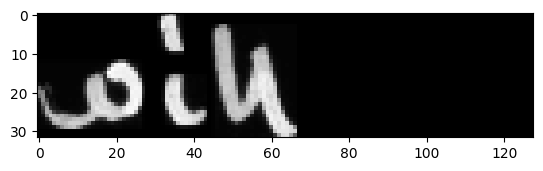



original_text =   probably
predicted text = probably

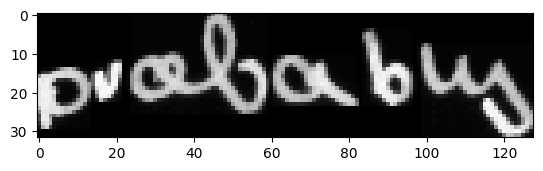



original_text =   discuss
predicted text = discuss

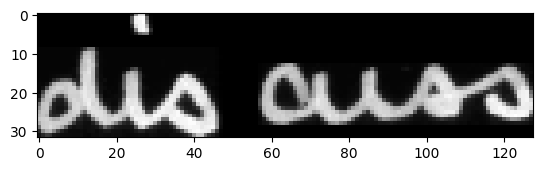



original_text =   the
predicted text = the

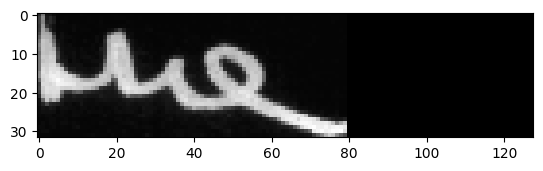



original_text =   with
predicted text = with

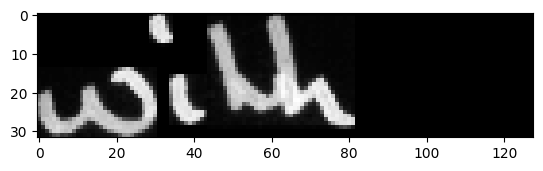



original_text =   Dr.
predicted text = Dr.

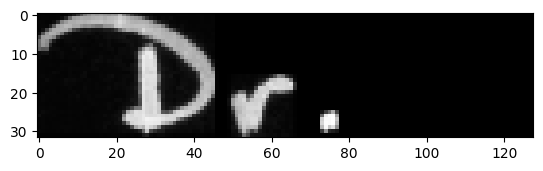



original_text =   Brentano
predicted text = Brentano

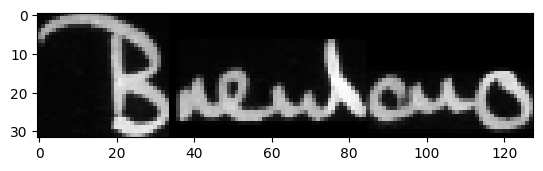



original_text =   ,
predicted text = ,

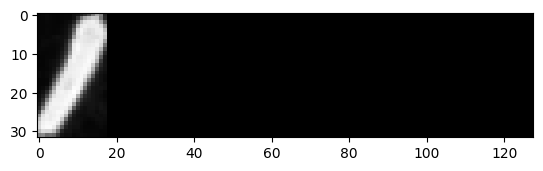



original_text =   the
predicted text = the

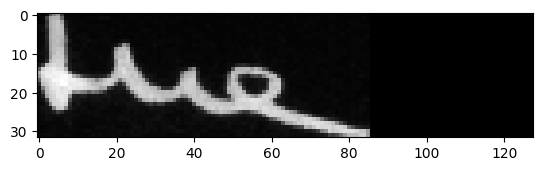



original_text =   West
predicted text = hest

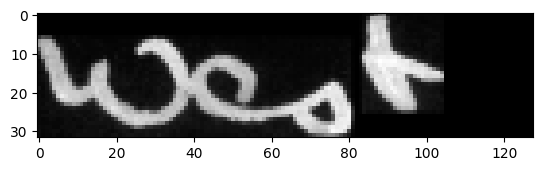



original_text =   German
predicted text = German

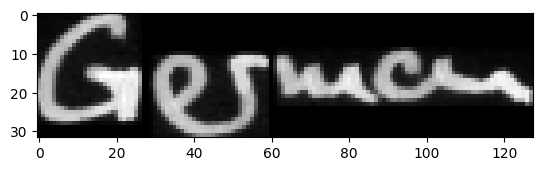



original_text =   Foreign
predicted text = Foreign

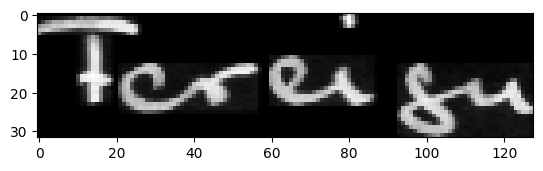



original_text =   Minister
predicted text = Minister

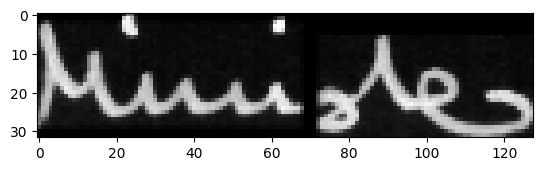



original_text =   who
predicted text = who

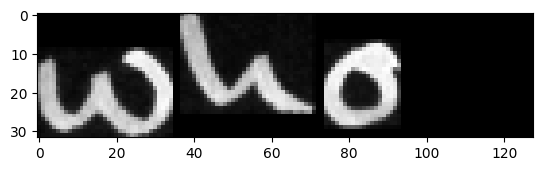



original_text =   is
predicted text = iss

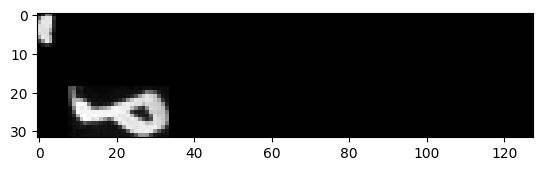



original_text =   due
predicted text = due

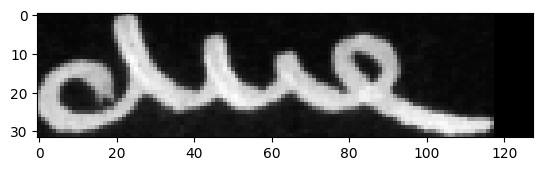

In [21]:
# predict outputs on validation images
prediction =act_model.predict(train_images[542:645])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("original_text =  ", train_original_text[542+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[542+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

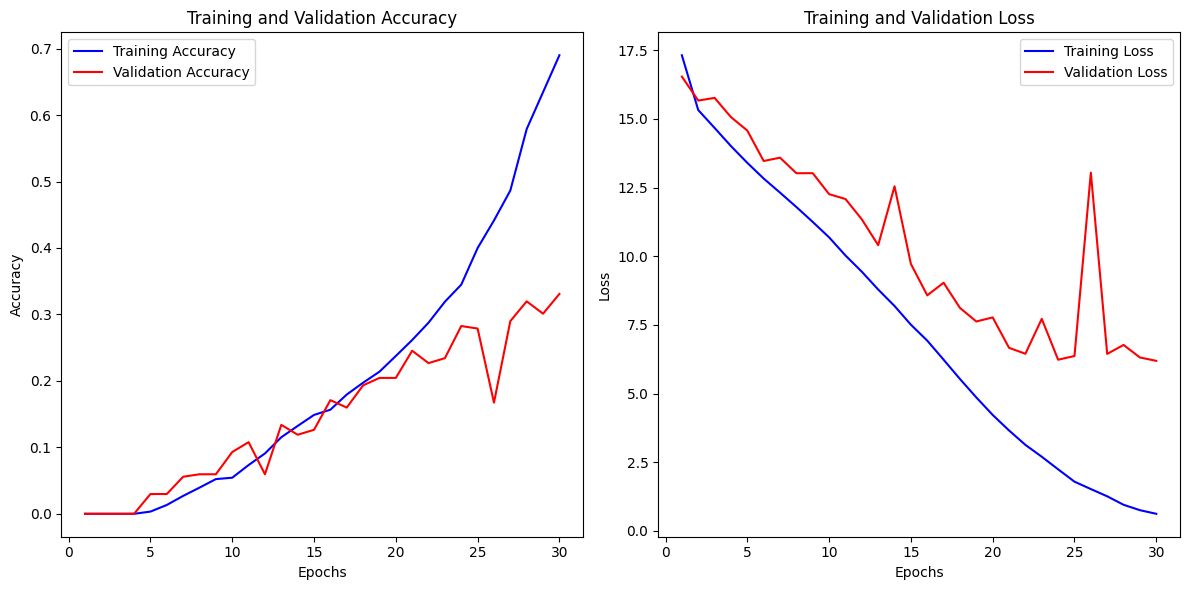

In [22]:
# Extract data from the history object
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "b", label="Training Accuracy")
plt.plot(epochs, val_acc, "r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

#Save the plot in 'model/output/'
plot_filename = 'model/working/Accuracy_Loss_Plot.png'  # Specify the desired file name and extension
plt.savefig(plot_filename)

plt.tight_layout()
plt.show()

In [23]:
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [24]:
with open('model/working/history.txt', 'a') as f:
    new_data = '{},{},{},{},{},{},{},{},{},{}\n'.format(filepath, 
                                                      optimizer_name, 
                                                      str(RECORDS_COUNT), 
                                                      e, 
                                                      str(train_images.shape[0]),
                                                      str(valid_images.shape[0]), 
                                                      best_loss, 
                                                      best_acc, 
                                                      best_val_loss, 
                                                      best_val_acc)
    f.write(new_data)

In [25]:
model.save('model/working/Text_recognizer_Using_CRNN.h5')